# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 11.11.2021

Мягий дедлайн: 23:59MSK 23.11.2021

Жестокий дедлайн: 23:59MSK 26.11.2021

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/31332/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 10

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

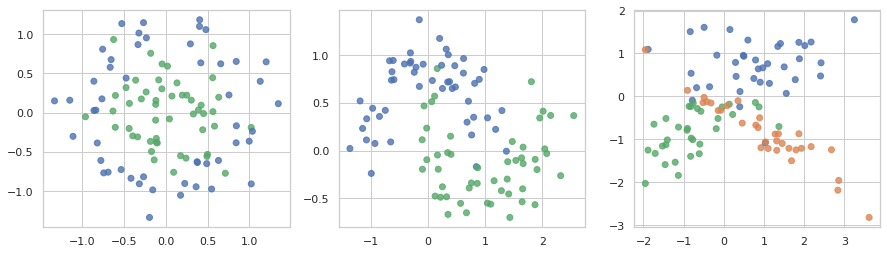

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [41]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

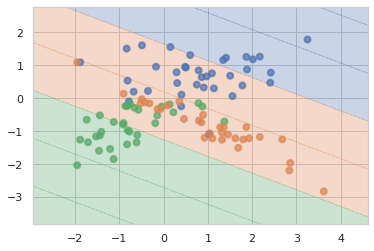

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

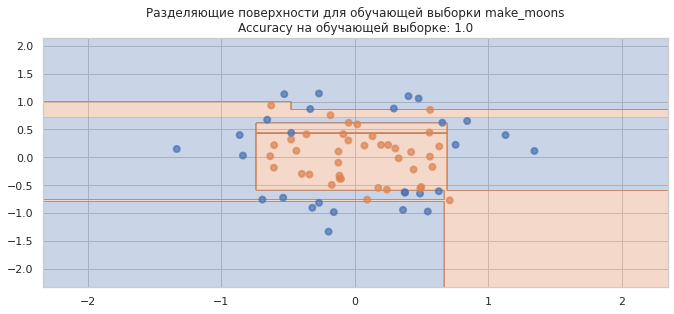

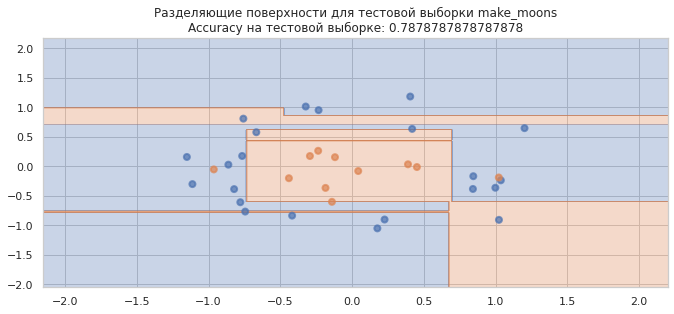

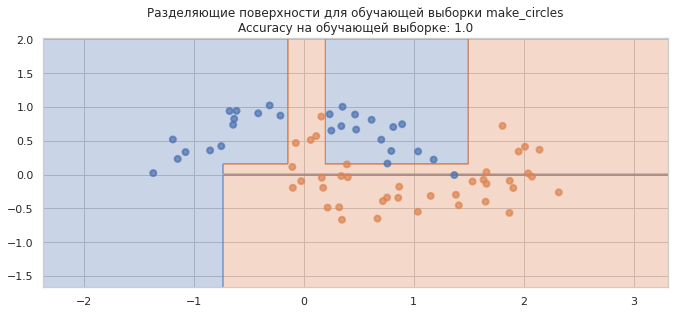

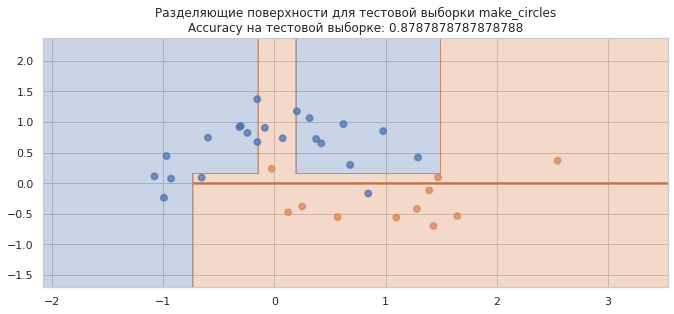

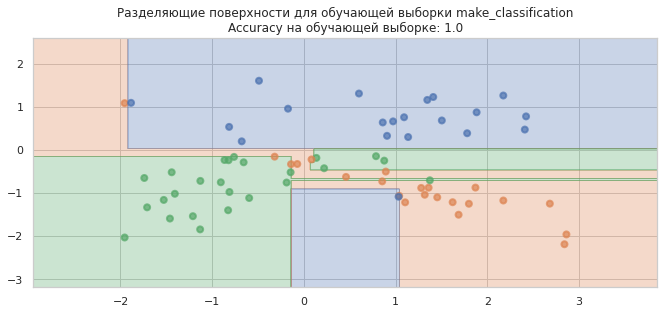

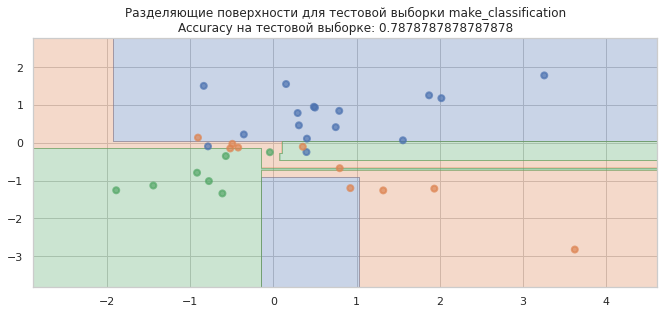

In [44]:
data_name = {0: 'make_moons', 1: 'make_circles', 2: 'make_classification'}

for i in range(3):
  # загружаем датасет, делим на трейн-тест, обучаем дерево
  X, y = datasets[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)

  # рисуем разделяющую поверхность для обучающей выборки
  plt.figure(figsize=(10, 5))
  plt.title('Разделяющие поверхности для обучающей выборки ' 
            + str(data_name[i]) + '\nAccuracy на обучающей выборке: ' + str(clf.score(X_train, y_train)))
  plot_surface(clf, X_train, y_train)

  # рисуем разделяющую поверхность для тестовой выборки
  plt.figure(figsize=(10, 5))
  plt.title('Разделяющие поверхности для тестовой выборки ' 
            + str(data_name[i]) + '\nAccuracy на тестовой выборке: ' + str(clf.score(X_test, y_test)))
  plot_surface(clf, X_test, y_test)

__Ответ:__ Да, деревья сильно перебучились: на тренировочной выборке они показывают идеальный результат, в то время как на тестовой выборке результат значительно хуже (хотя в целом не так плох).

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Код ниже вдохновлен семинаром [майнора](https://github.com/hse-ds/iad-intro-ds/blob/master/2021/seminars/sem12_trees/sem12_trees.ipynb). Не захотелось пользоваться функцией plot_surface, т.к. в ней реализована отрисовка и поэтому не получалось нарисовать так красиво по строчкам-столбикам. Было бы по 18 графиков 3 раза --- ужасно.

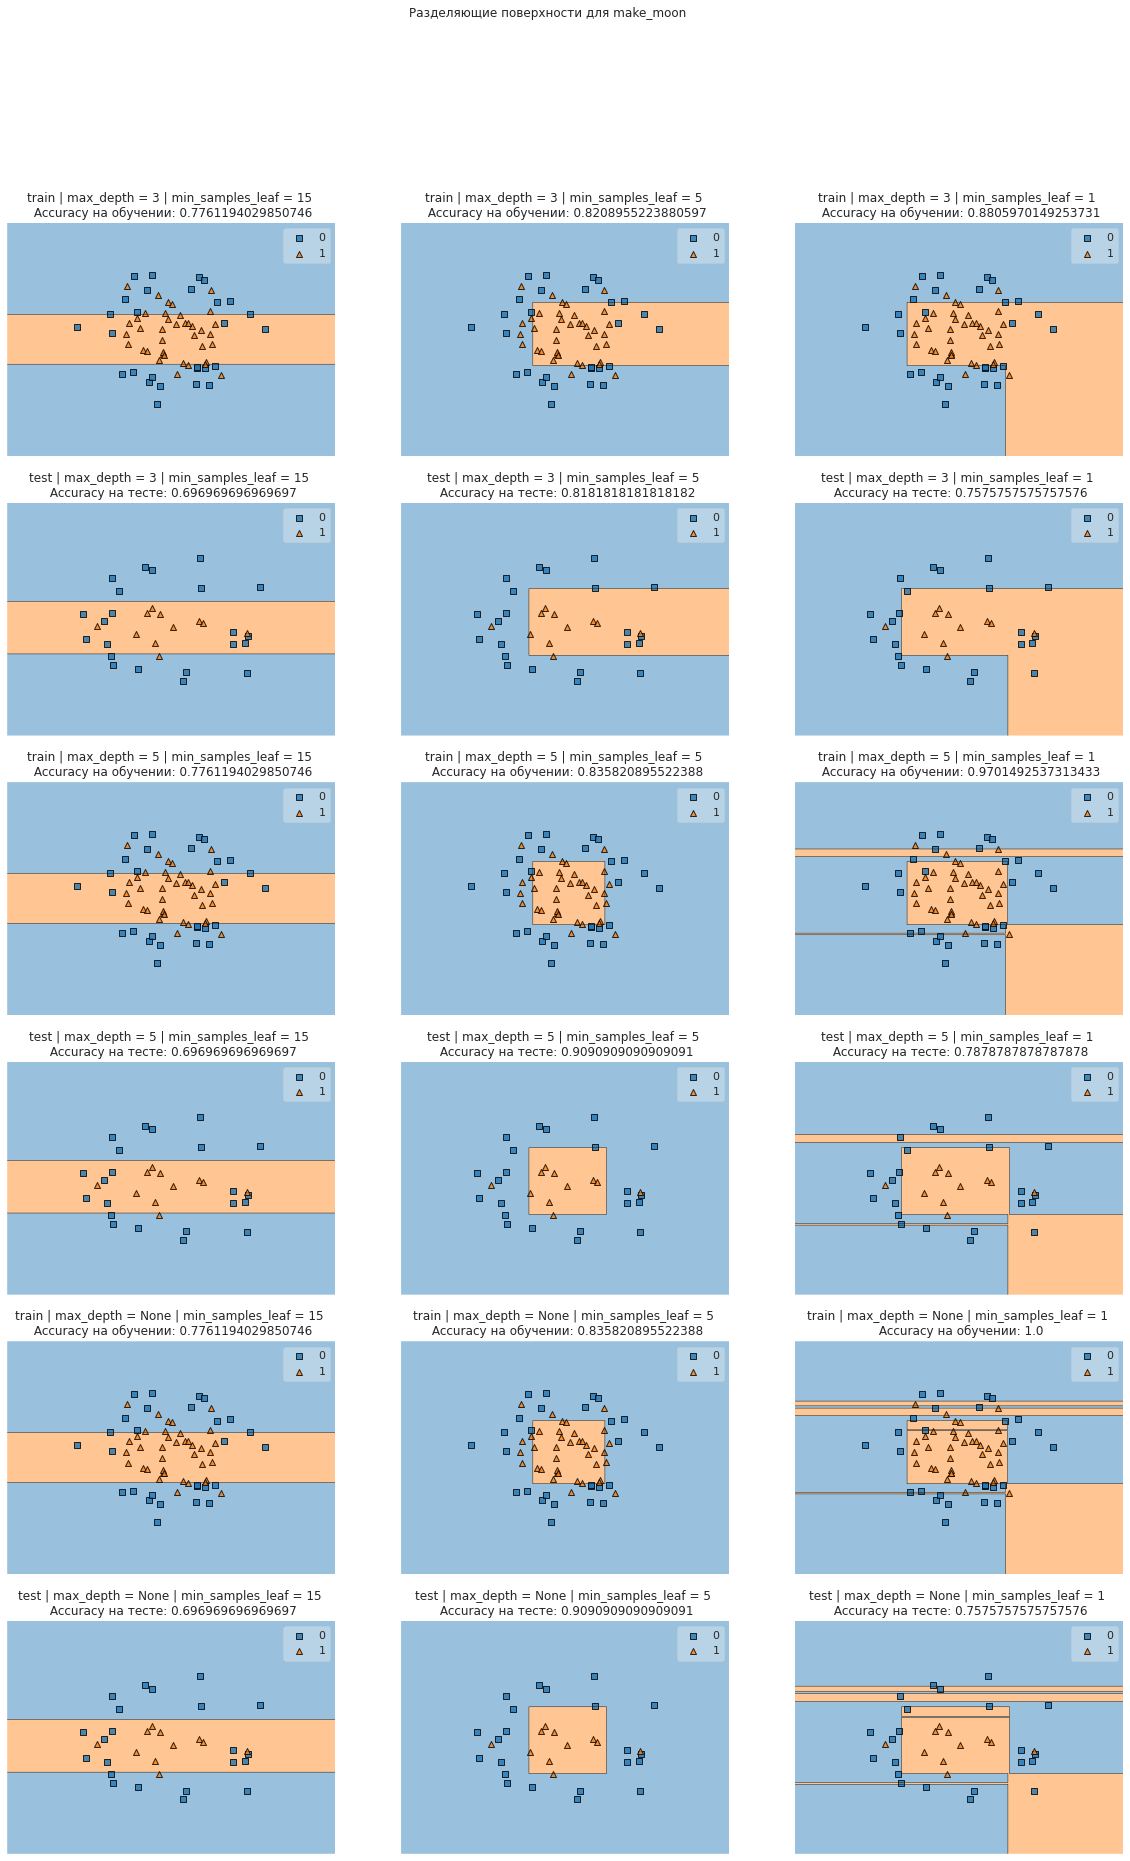

In [59]:
from mlxtend.plotting import plot_decision_regions

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 30))
fig.suptitle('Разделяющие поверхности для make_moon')
X, y = datasets[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)

        # рисуем для обучения
        ax[2 * i][j].set_title("train | max_depth = {} | min_samples_leaf = {} \n Accuracy на обучении: {}".format(
            max_depth, min_samples_leaf, dt.score(X_train, y_train)))
        ax[2 * i][j].axis("off")
        plot_decision_regions(X_train, y_train, dt, ax=ax[2 * i][j])

        # рисуем для теста
        ax[2 * i + 1][j].set_title("test | max_depth = {} | min_samples_leaf = {} \n Accuracy на тесте: {}".format(
            max_depth, min_samples_leaf, dt.score(X_test, y_test)))
        ax[2 * i + 1][j].axis("off")
        plot_decision_regions(X_test, y_test, dt, ax=ax[2 * i + 1][j])

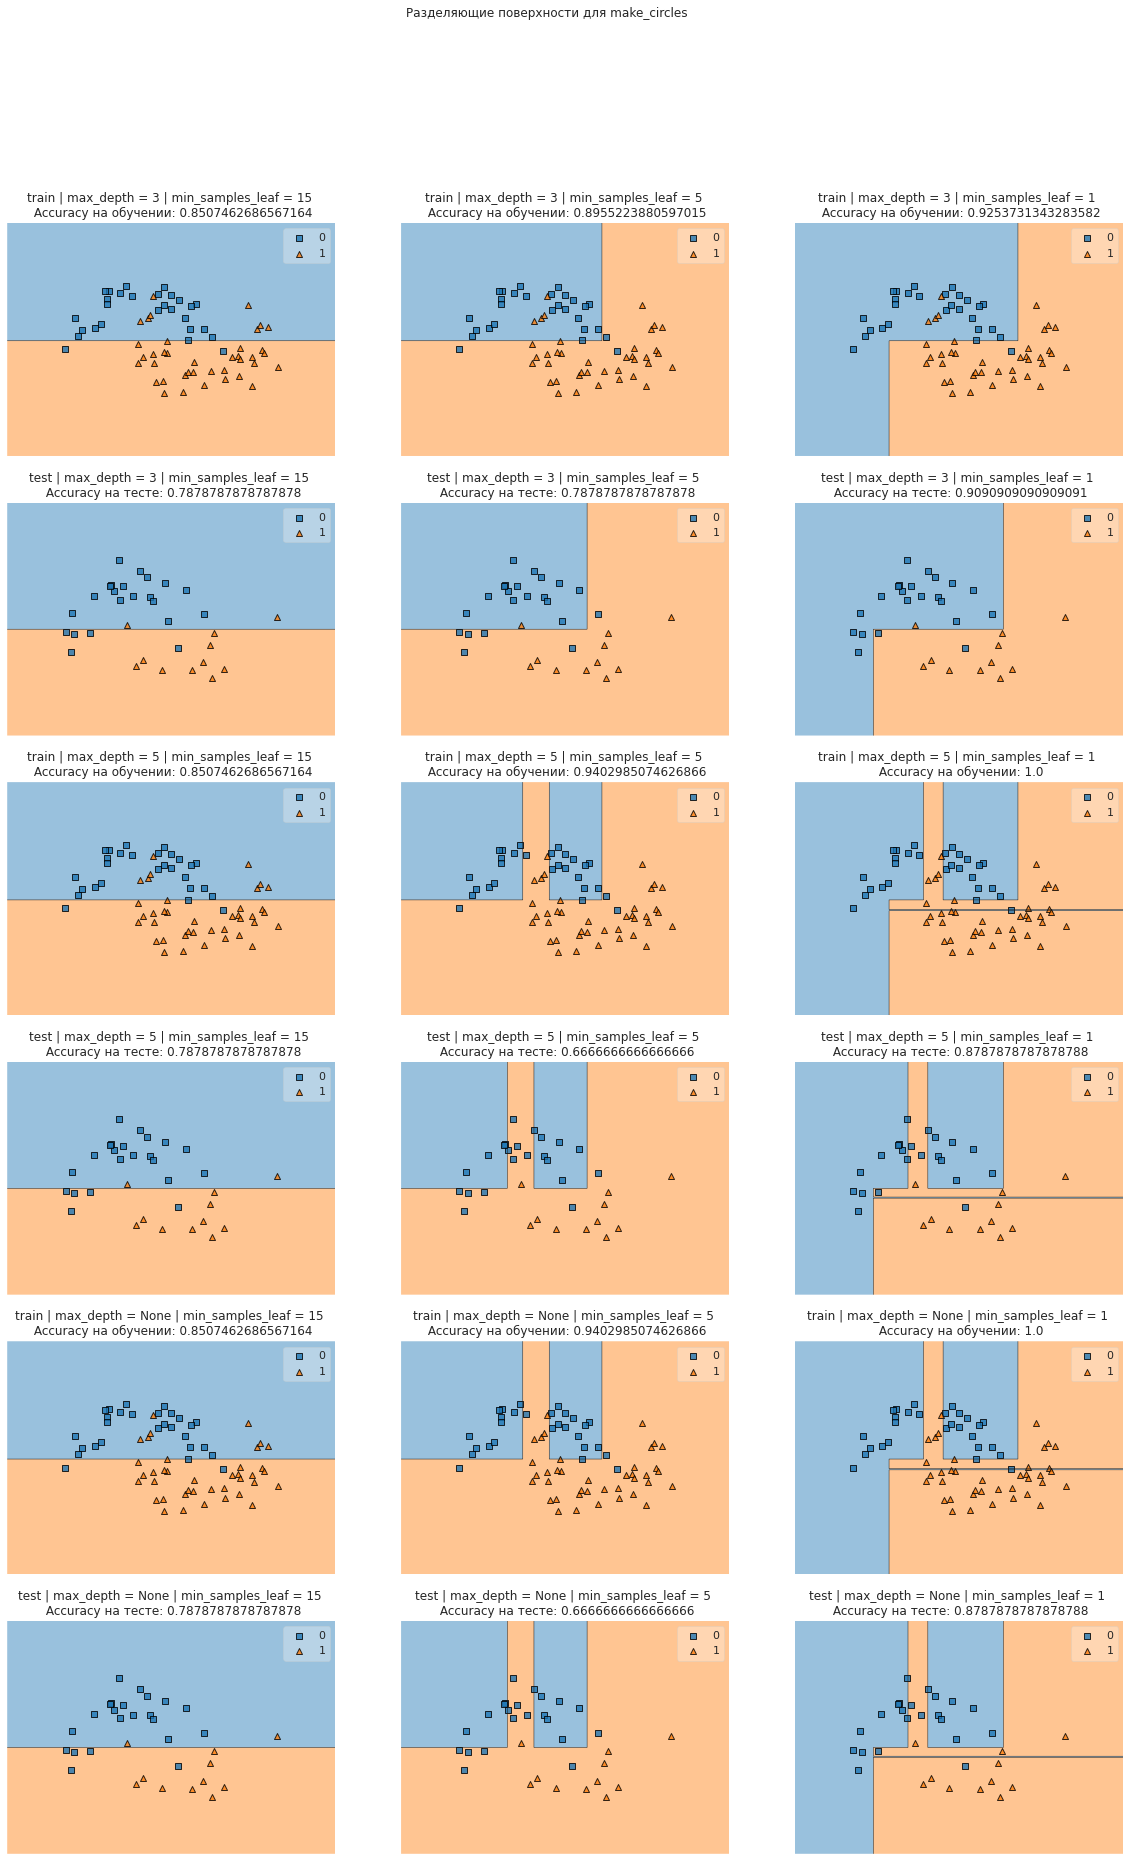

In [60]:
from mlxtend.plotting import plot_decision_regions

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 30))
fig.suptitle('Разделяющие поверхности для make_circles')
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)

        # рисуем для обучения
        ax[2 * i][j].set_title("train | max_depth = {} | min_samples_leaf = {} \n Accuracy на обучении: {}".format(
            max_depth, min_samples_leaf, dt.score(X_train, y_train)))
        ax[2 * i][j].axis("off")
        plot_decision_regions(X_train, y_train, dt, ax=ax[2 * i][j])

        # рисуем для теста
        ax[2 * i + 1][j].set_title("test | max_depth = {} | min_samples_leaf = {} \n Accuracy на тесте: {}".format(
            max_depth, min_samples_leaf, dt.score(X_test, y_test)))
        ax[2 * i + 1][j].axis("off")
        plot_decision_regions(X_test, y_test, dt, ax=ax[2 * i + 1][j])

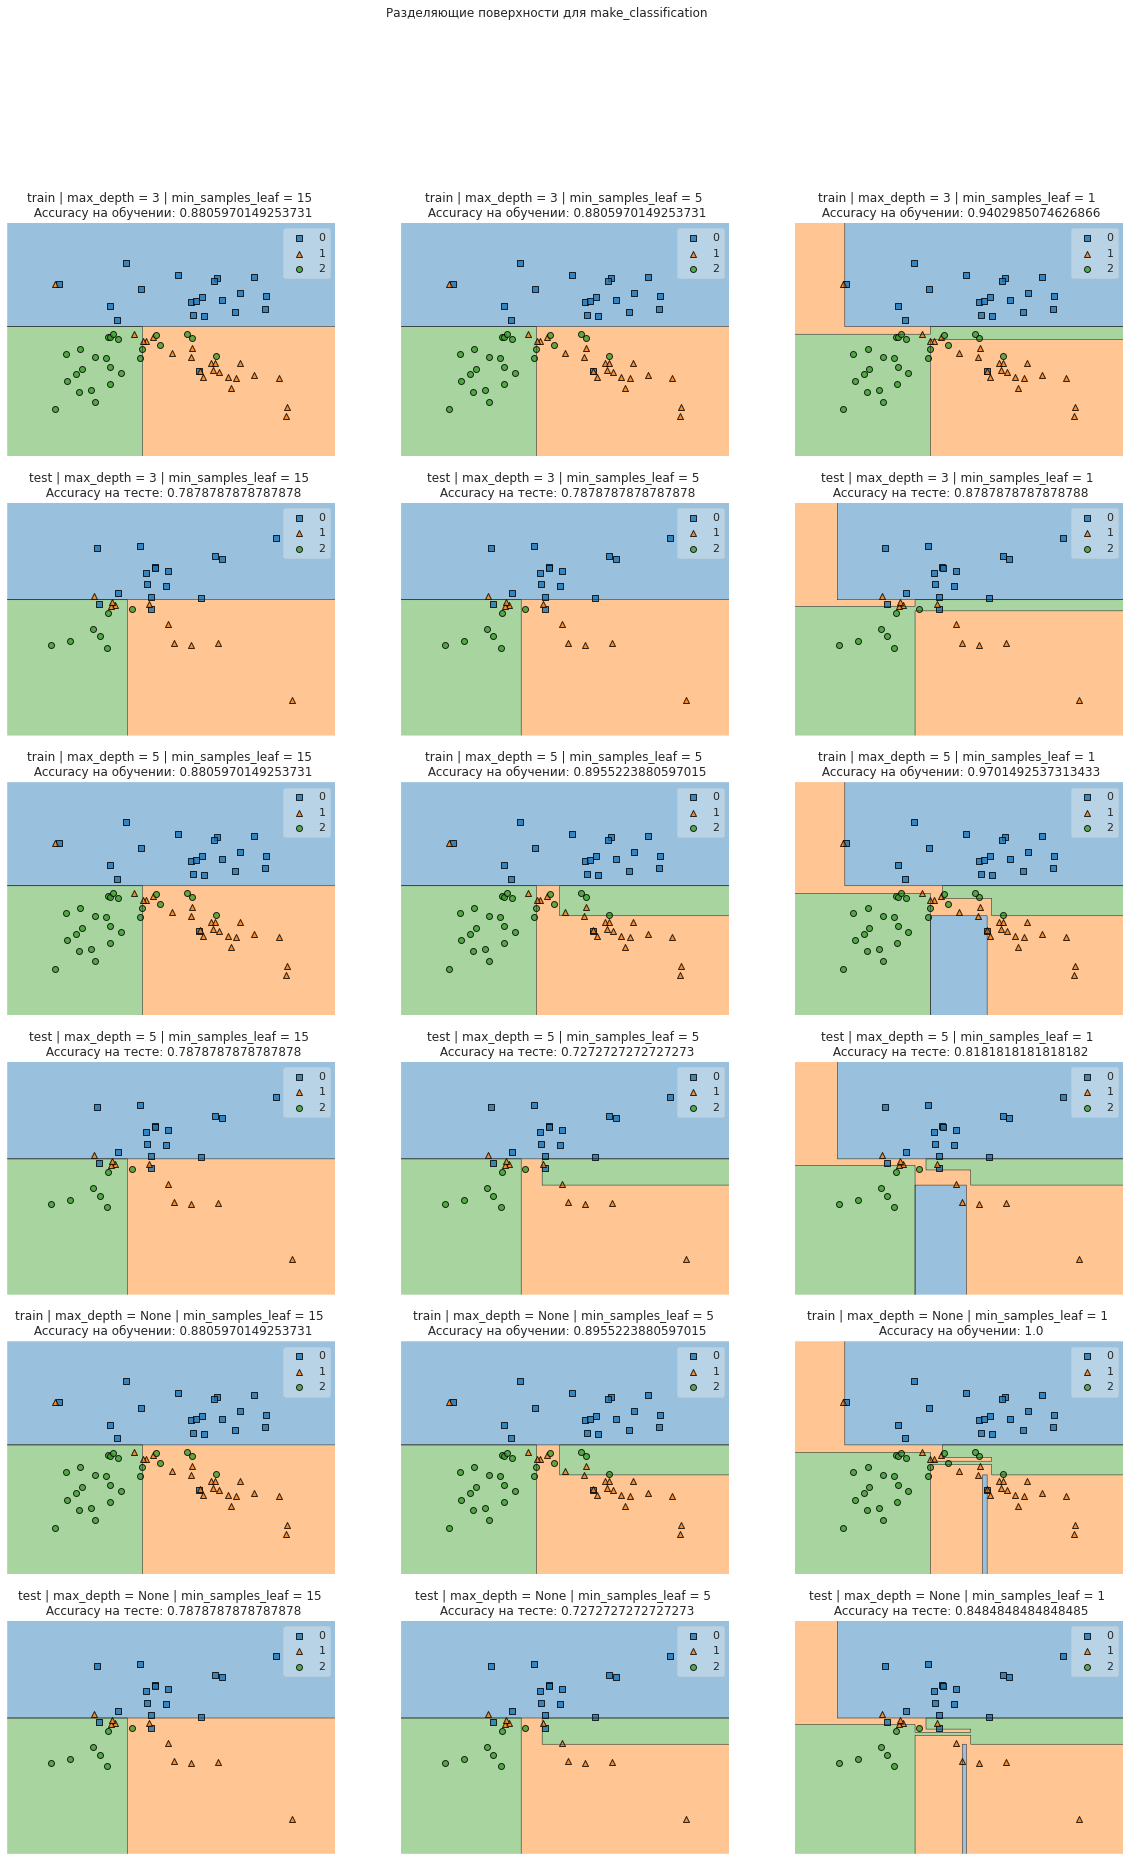

In [61]:
from mlxtend.plotting import plot_decision_regions

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 30))
fig.suptitle('Разделяющие поверхности для make_classification')
X, y = datasets[2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)

        # рисуем для обучения
        ax[2 * i][j].set_title("train | max_depth = {} | min_samples_leaf = {} \n Accuracy на обучении: {}".format(
            max_depth, min_samples_leaf, dt.score(X_train, y_train)))
        ax[2 * i][j].axis("off")
        plot_decision_regions(X_train, y_train, dt, ax=ax[2 * i][j])

        # рисуем для теста
        ax[2 * i + 1][j].set_title("test | max_depth = {} | min_samples_leaf = {} \n Accuracy на тесте: {}".format(
            max_depth, min_samples_leaf, dt.score(X_test, y_test)))
        ax[2 * i + 1][j].axis("off")
        plot_decision_regions(X_test, y_test, dt, ax=ax[2 * i + 1][j])

__Ответ:__ Видим, что слишком большое минимальное число объектов в листе (min_samples_leaf) чрезмерно обобщает, поэтому и на обучении, и на тесте результаты не очень. Это понятно, ведь иногда так много объектов действительно могут не относиться к одному классу. На обучении, конечно, min_samples_leaf = 1 дает лучший результат, т.к. позволяет сильнее всего подогнаться под выборку. Но на тесте чуть больший размер дает лучший результат, т.к. обобщающая способность получается лучше (но это не так, если для разделения классов нам просто провести линию --- тогда размер 1 даст лучший результат. Но если устройство посложнее, то подгон под выборку не даст ничего хорошего). Понятно, что не очень глубокое дерево не успевает хорошо узнать выборку, поэтому при маленькой глубине результаты не очень. При неограниченной глубине видим, что дерево сильно подгоняется под выборку (видно по правому столбику), поэтому, если устройство не слишком простое, то на тесте результат хуже, чем при среднем значении глубины (хотя если простое, то опять-таки --- неограниченное будет лучше среднего. Но лучше всего будет маленькая глубина, чтобы не успеть намудрить). 

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

**Ответ**. Вот посылка: https://contest.yandex.ru/contest/31332/run-report/59256186/ Ник в контесте: a.dtc

In [7]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # в качестве порогов нужно брать среднее двух соседних при сортировке значений признака. Отсортируем:
    thresholds = np.sort(np.unique(feature_vector))

    # обработаем вещественный случай. Надо брать среднее соседних. Сделаю для этого два новых вектора: в одном все
    # признаки, кроме последнего, а в другом --- все, кроме первого. Сложу их поэлементно и поделю на 2. Например,
    # если было 1-2-3-4, то будут два вектора: 2-3-4, 1-2-3. Сложу и поделю на 2: (1 + 2)/2-(2 + 3)/2-(3 + 4)/2
    t_first = thresholds[:-1]
    t_last = thresholds[1:]
    thresholds = (t_first + t_last) / 2

    # мощность множества объектов:
    R = len(target_vector)

    # отсортируем по feature_vector таргет и сам feature_vector
    sorted_target = target_vector[np.argsort(feature_vector)]
    sorted_features = np.sort(feature_vector)
    sorted_features, index = np.unique(sorted_features, return_index=True)

    # если index = [0, 4, 9, 15], то элементы с индексами в [0, 4) попадут в одно разбиение по первому
    # порогу, остальное --- в другое. т.е. 4, 9, 15 --- такие крайние индексы элементов при разбиении
    # (первый выкидываем, т.к. не рассматриваем пороги, приводящие к попаданию в одно из поддеревьев
    # пустого множества объектов)
    # => если разбиение по первому порогу, то в левое поддерево попадут 4 объекта, по второму --- 9 и т.д.
    # а в правое напротив: R - 4 объекта, R - 9 объектов, R - 15 объектов
    index = index[1:]
    R_L = index  # размер левого разбиения
    R_R = R - R_L  # размер правого разбиения

    # в np.cumsum(sorted_target) на i-м месте лежит сумма элементов sorted_target от 0 до i - 1
    # т.о., в target_vector_L(R) на i-м месте лежит число элементов с target = 1
    target_vector_L = np.array(np.cumsum(sorted_target))[index - 1]  # index - 1, т.к. край в index невкл
    # сколько всего единичных значений - сколько в левом
    target_vector_R = np.array(np.sum(sorted_target) - target_vector_L)

    # доли классов для левого разбиения:
    p1 = target_vector_L / R_L
    p0 = 1 - p1

    # хаотичность для левого разбиения:
    H_L = 1 - p0 ** 2 - p1 ** 2

    # доли классов для правого разбиения:
    p1 = target_vector_R / R_R
    p0 = 1 - p1

    # хаотичность для правого разбиения:
    H_R = 1 - p0 ** 2 - p1 ** 2

    # наконец, посчитаем Джини
    ginis = -1 * R_L / R * H_L - R_R / R * H_R

    # Джини чем больше, тем лучше (раз мы берем Джини с минусом по заданию)
    ginis_best = np.max(ginis)
    threshold_best = thresholds[np.argmax(ginis)]

    return thresholds, ginis, threshold_best, ginis_best

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

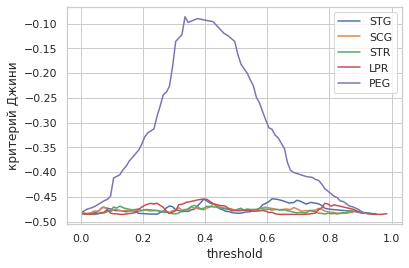

In [11]:
data = pd.read_csv('students.csv')

feats = data.iloc[:, :5]
target = data.iloc[:, -1]
names = data.columns

for i in range(5):
    thresholds, variances, threshold_best, variance_best = find_best_split(data.iloc[:, i], target)
    plt.plot(thresholds, variances, label = names[i])
    
plt.legend()
plt.xlabel("threshold")
plt.ylabel("критерий Джини")
plt.show()

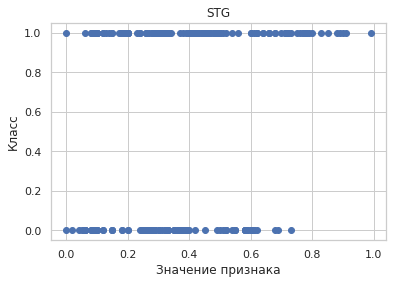

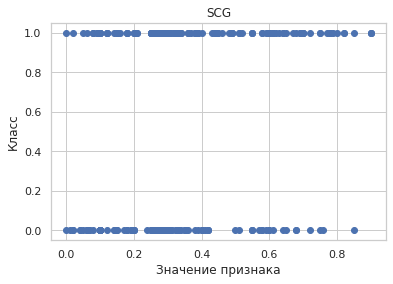

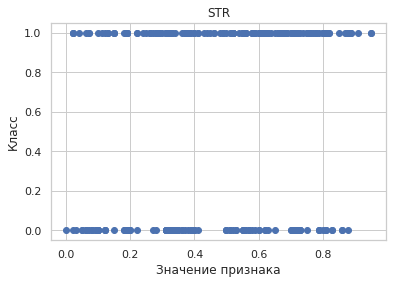

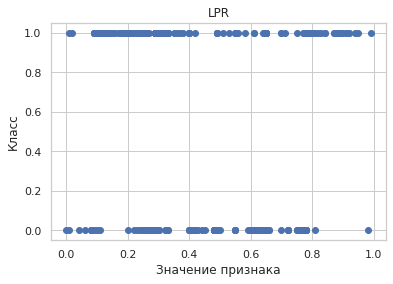

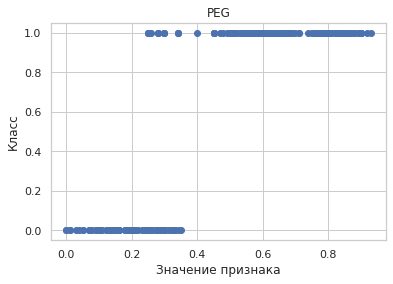

In [12]:
for i in range(5):
    plt.scatter(data.iloc[:, i], target)
    plt.title(names[i])
    plt.xlabel("Значение признака")
    plt.ylabel("Класс")
    plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Наибольший критерий Джини --- т.е. наиболее близкий к нулю (а значит, когда хаотичность наиболее близка к нулю: что нам и нужно) --- когда производим отбор по PEG, причем разница с отбором по остальным признакам довольно значительная.

Действительно, для scatter-графика PEG мы можем провести вертикальную линию (порог) так, чтобы классы достаточно хорошо разделились. Для остальных графиков видим, что сделать это сносно не удастся.

Вид кривой для "хороших" признаков имеет одну явную вершину-выпуклость, в ее совсем вершине как раз хорошее разбиение. Если критерий Джини в целом сначала все лучше и лучше (кривая возрастает), а потом все хуже и хуже (кривая убывает), то поделится хорошо. А если критерий то улучшается, то ухудшается, то обратно улучшается, то снова ухудшается, то выбрать порог, чтобы осмысленно поделить, вряд ли удастся, ведь мы не можем провести вертикальную линию так, чтобы отделить значения получше от значений похуже, они повторяются.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

 **Ответ**. Вот посылка: https://contest.yandex.ru/contest/31332/run-report/59275893/

In [90]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))
                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if len(np.unique(feature_vector)) <= 1:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature_best = node["feature_split"]
        if self._feature_types[feature_best] == "categorical":
            if x[feature_best] in node["categories_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            if x[feature_best] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

    def get_params(self, deep=False):
        return {'feature_types': self._feature_types,
                'max_depth': self._max_depth,
                'min_samples_split': self._min_samples_split,
                'min_samples_leaf': self._min_samples_leaf}

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [114]:
from sklearn import preprocessing
mushrooms = pd.read_csv('agaricus-lepiota.data').apply(preprocessing.LabelEncoder().fit_transform)

# отделяю признаки от таргета
feat = mushrooms.iloc[:, 1:]
target = mushrooms.iloc[:, 0]

# разбиваю на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(feat, target, test_size=0.5, random_state=42)

# обучаю
Tree = DecisionTree(["categorical"] * feat.shape[1])
Tree.fit(np.array(X_train), np.array(y_train))  # т.к. функция принимает ndarray, а не dataframe

# предсказываю и оцениваю
y_pred = Tree.predict(np.array(X_test))
print(accuracy_score(y_test, y_pred))

1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [171]:
# загружаем данные
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data')
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data')
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')    

In [115]:
# сделаем преобразования с названиями классов, которые описаны в задании
cars['unacc'] = cars['unacc'].apply(lambda x: 1 if (x == 'good' or x == 'vgood') else 0)
nursery['recommend'] = nursery['recommend'].apply(lambda x: 1 if (x == 'not_recom' or x == 'spec_prior') else 0)

In [116]:
# кодируем (не разбираю, какие признаки категориальные, какие числовые, т.к. в документации есть пример,
# что для числовых признаков получается нормирование, --- всегда ничем не плохо)
tic_tac_toe = tic_tac_toe.apply(preprocessing.LabelEncoder().fit_transform)
nursery = nursery.apply(preprocessing.LabelEncoder().fit_transform)
cars = cars.apply(preprocessing.LabelEncoder().fit_transform)

In [117]:
# отделяем признаки от таргета
y_mushrooms = mushrooms['p'].values
y_tic_tac_toe = tic_tac_toe['positive'].values
y_cars = cars['unacc'].values
y_nursery = nursery['recommend'].values

mushrooms = mushrooms.iloc[:, 1:]
tic_tac_toe = tic_tac_toe.iloc[:, :-1]
cars = cars.iloc[:, :-1]
nursery = nursery.iloc[:, :-1]

In [161]:
def scores(feat, target):
    scores = {}
    scores['real'] = cross_val_score(DecisionTree(['real'] * len(feat.columns)), feat.values, 
                                     target, cv=10, scoring=make_scorer(accuracy_score)).mean()
    scores['categorical'] = cross_val_score(DecisionTree(['categorical'] * len(feat.columns)), 
                                         feat.values, target, cv=10, 
                                         scoring=make_scorer(accuracy_score)).mean()
    ohe_feat = OneHotEncoder(sparse=False).fit_transform(feat)
    scores['real + ohe'] = cross_val_score(DecisionTree(['real'] * len(ohe_feat)), ohe_feat, 
                                       target, cv=10, scoring=make_scorer(accuracy_score)).mean()
    scores['sklearn'] = cross_val_score(DecisionTreeClassifier(), feat.values, target, cv=10,
                                            scoring=make_scorer(accuracy_score)).mean()
    return scores

In [137]:
datasets = [mushrooms, tic_tac_toe, cars, nursery]
datasets_names = ['mushrooms', 'tic_tac_toe', 'cars', 'nursery']
targets = [y_mushrooms, y_tic_tac_toe, y_cars, y_nursery]
algo = ['real', 'categorical', 'real + ohe', 'sklearn']

In [162]:
result = pd.DataFrame(columns=algo, index=datasets_names)
for i in range(len(datasets)):
    result.loc[datasets_names[i], :] = scores(datasets[i], targets[i]) 

In [163]:
result

,real,categorical,real + ohe,sklearn
mushrooms,0.999261,1,0.999631,0.95829
tic_tac,0.467939,0.549265,0.55352,0.756985
cars,0.939693,0.967519,0.921767,0.944371
nursery,0.907716,0.90787,0.866358,0.790858


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ**. Лучшие результаты на mushrooms, где баланс классов очень хороший. Для всех остальных датасетов баланс классов значительно хуже. Это влияет на качество работы алгоритмов --- поэтому на mushrooms лучшие результаты.

Хуже всего результаты на tic-tac-toe. Посмотрим на сам датасет, чтобы разобраться. Вот, что про него написано: this database encodes the complete set of possible board configurations. Т.е. влияние признаков на таргет гораздо менее очевидное, чем для всех остальных датасетов. Когда мы кодирум признаки числами, мы так или иначе вводим какой-то порядок на них. В данном случае непонятно, какой порядок может быть адекватным и какая вообще закономерность может быть найдена на числах, кодирующих доску, если связь всех признаков с таргетом не самая очевидная (и явно куда глубже, чем в датасете nursery, например, --- про nursery ниже). Однако в зависимости от того, каким образом мы закодируем положения с помощью LabelEncoder, результат может меняться (понятно, что какие-то способы окажутся более удачными, чем другие, потому что, пусть и неспециально, но учтут какую-то связь). Думаю, что именно исходя из такой специфики признаков мы и получаем результат при real + ohe лучше, чем просто при real: в такой задаче очень вероятно получить неадекватное по смыслу кодирование признаков, которое будет только путать модель. Если никакой лишней связи (хотя и можно попробовать подобрать адекватную связь --- но простым кодированием LabelEncoder, вероятнее всего, мы получим совсем не ее) не создавать вообще, то результат оказывается лучше. Просто считать все признаки категориальными дает почти такой же результат, не думаю, что в том, почему есть разница в 0.004 при наличии доли случайности из-за LabelEncoder, есть глубокий смысл (может, при таком кодировании модели и было чуть удобнее сделать выводы). Модель из sklearn работает лучше, чем наша для всех категориальных, потому что ее дефолтные значения параметров дают лучший результат. Например, min_samples_split = 2. У нас None. Кажется, что это может сильно влиять на результат.

Заметим, что в датасете nursery признаки такие, что они могут трактоваться как порядковые. Поэтому, когда мы трактуем значения как числовые, модель действительно может найти закономерность. При real + ohe эта особенность теряется, поэтому и результат хуже.

Как раз из этого видим, что случайность присутствует, --- мы кодируем признаки с помощью LabelEncoder, и непонятно, какой порядок такая кодировка задаст. Если мы будем кодировать вручную и выбирать для признаков, на которых действительно есть порядок, осмысленное кодирование (convenient > less_conv > critical), модель сможет лучше найти закономерность.

Кажется, что в датасете грибы типичные категориальные признаки, и раз модель позволяет нам их так интерпретировать и у нас есть хороший алгоритм для обработки категориальных признаков, то хорошо их и считать категориальными (хотя в целом кажется не очень правильным делать какие-то выводы о том, лучше ли считать все категориальными или делать ohe + считать вещественными, когда разница в результате начинается в четвертом знаке после запятой). На них нет никакого порядка, поэтому real дает результаты похуже, а связь переменных с таргетом из естественных соображений кажется более очевидной, чем в датасете про игру в крестики-нолики. Модель из sklearn может давать результат похуже опять-таки из-за дефолтных параметров.

В датасете cars на всех признаках может быть порядок (низкая безопасность хуже средней), поэтому real дает хороший результат. Однако из-за LabelEncoder неясно, какой именно порядок задастся (из-за этого может быть хуже и качество). Если бы мы задали кодирование вручную, возможно, результат для real был бы лучше. Думаю, что поэтому мы получаем результат для categorical лучше. Наша модель дает результат лучший, чем модель из sklearn, возможно, опять-таки из-за более удачного набора дефолтных параметров. real + ohe дает результат чуть хуже, чем real: возможно, потому что теперь стало много параметров => тяжелее уловить закономерность. Результат хуже, чем для categorical, ведь в categorical сохраняется смысл значений, на который модель и опирается. Увидев дисбаланс классов, я проверила, какой результат даст константный прогноз 0: оказался 0.92, так что кажется, что у моделей была не самая сложная задача))


Ниже смотрю на баланс классов.

(array([332.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 625.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

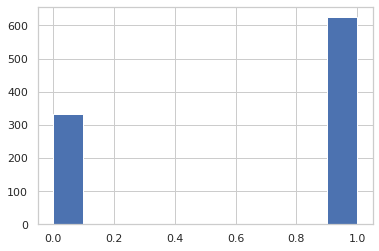

In [165]:
plt.hist(y_tic_tac_toe)

(array([4208.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3915.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

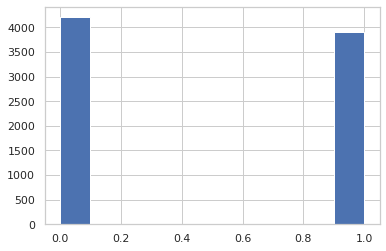

In [166]:
plt.hist(y_mushrooms)

(array([1593.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         134.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

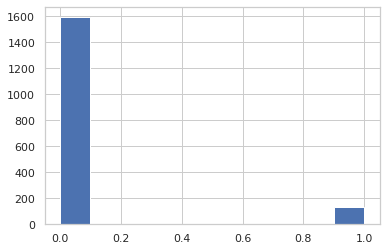

In [167]:
plt.hist(y_cars)

(array([4595.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8364.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

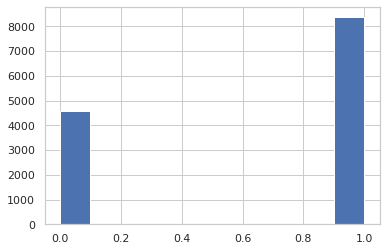

In [170]:
plt.hist(y_nursery)